In [ ]:
# Generate plots for
# Main Text Fig. 4 of "Noise-Enabled Goal Attainment in Crowded Collectives"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)  # creates "figures" if missing

plt.style.use('./traffic_figures.mplstyle')
num_robots_palette = sns.color_palette("magma_r")

In [ ]:
time_cutoff = 6000
end_time = 8000

data_dir = '../simulation_data/'

ministage_agents_data_filename = "fig4_local_agents_data.txt" # data on individual agent positions, goals, etc
ministage_stats_data_filename = "fig4_local_trials_data.txt" # data on trial runtime

astar_agents_data_filename = "fig4_astar_agents_data.txt"
astar_stats_data_filename = "fig4_astar_planner_data.txt"


In [63]:
def goals_reached_between(df, time_a, time_b, extra_variables = []):
    goalsreached = df[(df['sim_time'].isin([time_a, time_b]))][['trial', 'periodic', 'num_robots', 'noise', 'sim_time', 'robot_id', 'goals_reached'] + extra_variables].drop_duplicates()
    goalsreached = goalsreached.pivot(index=['trial', 'periodic', 'num_robots', 'noise', 'robot_id'] + extra_variables, columns='sim_time', values='goals_reached').reset_index() # cast data for two times into two separate columns
    
    # goals each robot in each trial reaches between time and b
    goalsreached['goals_in_interval'] = goalsreached[time_b] - goalsreached[time_a]

    # goals all robots together reach
    goalsreached_trial = goalsreached.groupby(['trial', 'noise', 'num_robots', 'periodic'] + extra_variables, observed=False).agg(goals_reached_trial = (time_b, 'sum'), 
                                                                                                            latesim_goals_trial = ('goals_in_interval', 'sum')).reset_index()
    
    return goalsreached_trial

In [64]:
def goals_reached_between_astar(df, time_a, time_b, extra_variables = []):
    goalsreached = df[(df['sim_time'].isin([time_a, time_b]))][['trial', 'periodic', 'num_robots', 'sim_time', 'robot_id', 'goals_reached'] + extra_variables].drop_duplicates()
    goalsreached = goalsreached.pivot(index=['trial', 'periodic', 'num_robots', 'robot_id'] + extra_variables, columns='sim_time', values='goals_reached').reset_index() # cast data for two times into two separate columns
    
    # goals each robot in each trial reaches between time and b
    goalsreached['goals_in_interval'] = goalsreached[time_b] - goalsreached[time_a]

    # goals all robots together reach
    goalsreached_trial = goalsreached.groupby(['trial', 'num_robots', 'periodic'] + extra_variables, observed=False).agg(goals_reached_trial = (time_b, 'sum'), 
                                                                                                            latesim_goals_trial = ('goals_in_interval', 'sum')).reset_index()
    
    return goalsreached_trial

## Local Methods Data

In [ ]:
ministage_df = pd.read_csv(data_dir + ministage_agents_data_filename, index_col = False)


ministage_end_time = np.max(ministage_df['sim_time'])
ministage_df['robot_id'] = ministage_df['robot_id'].astype('int')
ministage_df['goal_age'] = (ministage_df['sim_time'] - ministage_df['goal_birth_time']) / ministage_end_time
ministage_df['noise_type'] = ministage_df['addtl_data']

In [66]:
ministage_df

,trial,periodic,num_robots,noise,noise_prob,sim_time,robot_id,x_pos,y_pos,angle,goal_x_pos,goal_y_pos,goal_birth_time,goals_reached,stopped,nearby_robot,noise_type,goal_age
0,0,1,1,-1.0,1.0,0.0,0,14.73,16.87,0.50,13.27,5.77,0,0,0,-1,constant noise,0.000000
1,0,1,1,-1.0,1.0,1000.0,0,14.35,9.47,1.26,-0.93,13.91,653,1,0,-1,constant noise,0.043375
2,0,1,1,-1.0,1.0,2000.0,0,-14.44,-10.59,0.61,-0.93,13.91,653,1,0,-1,constant noise,0.168375
3,0,1,1,-1.0,1.0,3000.0,0,8.02,-16.85,0.77,-0.93,13.91,653,1,0,-1,constant noise,0.293375
4,0,1,1,-1.0,1.0,4000.0,0,17.58,-9.86,-2.59,-0.93,13.91,653,1,0,-1,constant noise,0.418375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3524261,19,1,256,-1.0,1.0,8000.0,251,2.93,12.26,-1.23,4.75,7.08,94,1,1,22,conditional noise,0.988250
3524262,19,1,256,-1.0,1.0,8000.0,252,-2.43,17.70,2.89,2.21,9.17,254,1,0,-1,conditional noise,0.968250
3524263,19,1,256,-1.0,1.0,8000.0,253,2.26,8.39,-3.13,7.28,5.53,1392,4,1,242,conditional noise,0.826000
3524264,19,1,256,-1.0,1.0,8000.0,254,-0.81,-6.38,-2.60,0.53,8.19,6936,2,1,13,conditional noise,0.133000


## AStar Data

In [ ]:
astar_end_time = end_time

astar_df = pd.read_csv(data_dir + astar_agents_data_filename, index_col = False)
astar_df.columns = astar_df.columns.str.strip()


astar_total_steps = np.max(astar_df['sim_step_time'])
astar_df['goal_age'] = (astar_df['sim_step_time'] - astar_df['goal_birth_time']) / astar_total_steps
astar_df['robot_id'] = astar_df['robot_id'].astype('int')

astar_df['sim_time'] = astar_df['sim_step_time'] * astar_end_time / astar_total_steps
astar_df


,trial,periodic,num_robots,sim_step_time,robot_id,x_pos,y_pos,goal_birth_time,goals_reached,noise_type,addtl_data,goal_age,sim_time
0,0,1,1,0.0,0,16,0,0.0,0,astar,NaN,0.000000,0.0
1,0,1,1,375.0,0,25,0,372.0,31,astar,NaN,0.001000,1000.0
2,0,1,1,750.0,0,26,11,744.0,62,astar,NaN,0.002000,2000.0
3,0,1,1,1125.0,0,17,11,1104.5,90,astar,NaN,0.006833,3000.0
4,0,1,1,1500.0,0,14,1,1496.5,120,astar,NaN,0.001167,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60655,19,1,128,3000.0,123,5,20,945.0,52,astar,NaN,0.685000,8000.0
60656,19,1,128,3000.0,124,15,23,1449.0,53,astar,NaN,0.517000,8000.0
60657,19,1,128,3000.0,125,3,21,636.0,36,astar,NaN,0.788000,8000.0
60658,19,1,128,3000.0,126,10,24,601.5,30,astar,NaN,0.799500,8000.0


## Pull steady state goal attainment rates

In [70]:
ministage_latesim = goals_reached_between(ministage_df, time_cutoff, end_time, extra_variables = ['noise_type'])
ministage_latesim['goal_rate'] = ministage_latesim['goals_reached_trial'] / end_time
ministage_latesim['latesim_goal_rate'] = ministage_latesim['latesim_goals_trial'] / (end_time - time_cutoff)

ministage_latesim

,trial,noise,num_robots,periodic,noise_type,goals_reached_trial,latesim_goals_trial,goal_rate,latesim_goal_rate
0,0,-1.0,1,1,conditional noise,274,75,0.034250,0.0375
1,0,-1.0,1,1,constant noise,2,0,0.000250,0.0000
2,0,-1.0,16,1,conditional noise,3626,894,0.453250,0.4470
3,0,-1.0,16,1,constant noise,24,4,0.003000,0.0020
4,0,-1.0,32,1,conditional noise,5640,1384,0.705000,0.6920
...,...,...,...,...,...,...,...,...,...
2595,19,1.5,128,1,constant noise,2866,712,0.358250,0.3560
2596,19,1.5,160,1,constant noise,1761,201,0.220125,0.1005
2597,19,1.5,192,1,constant noise,1075,43,0.134375,0.0215
2598,19,1.5,224,1,constant noise,826,59,0.103250,0.0295


In [71]:
astar_latesim = goals_reached_between_astar(astar_df, time_cutoff, end_time)
astar_latesim['latesim_goal_rate'] = astar_latesim['latesim_goals_trial'] / (end_time - time_cutoff)
astar_latesim['goal_rate'] = astar_latesim['goals_reached_trial'] / end_time


## Pull simulation runtimes

In [72]:
def runtime_between(df, time_a, time_b, extra_variables = []):
    runtime = df[(df['sim_time'].isin([time_a, time_b]))][['trial', 'periodic', 'num_robots', 'sim_time', 'runtime'] + extra_variables].drop_duplicates()
    runtime = runtime.pivot(index=['trial', 'periodic', 'num_robots'] + extra_variables, columns='sim_time', values='runtime').reset_index() # cast data for two times into two separate columns
    
    # wall-clock time elapsed between simulation times a and b
    runtime['latesim_runtime'] = np.round(runtime[time_b] - runtime[time_a], 5)

    runtime['runtime'] = runtime[time_b]

    return runtime

In [ ]:
astar_planner_stats_df = pd.read_csv(data_dir + astar_stats_data_filename, index_col = False)


astar_total_steps = np.max(astar_planner_stats_df ['sim_step_time'])
astar_planner_stats_df['sim_time'] = astar_planner_stats_df['sim_step_time'] * astar_end_time / astar_total_steps
astar_planner_stats_df['runtime'] = astar_planner_stats_df['wallclock_ms_since_start'] / 1000


# astar_planner_stats_df = astar_planner_stats_df[astar_planner_stats_df['sim_step_time'] == astar_total_steps]
astar_planner_stats_df = runtime_between(astar_planner_stats_df, time_cutoff, end_time, extra_variables=[])



In [ ]:
ministage_stats_df = pd.read_csv(data_dir + ministage_stats_data_filename, index_col = False)


ministage_stats_df['runtime'] = ministage_stats_df['runtime_ms'] / 1000
ministage_stats_df = runtime_between(ministage_stats_df, time_cutoff, end_time, extra_variables=["noise", "noise_type"])

ministage_stats_df

sim_time,trial,periodic,num_robots,noise,noise_type,6000.0,8000.0,latesim_runtime,runtime
0,0,1,1,-1.0,conditional noise,0.015,0.019,0.004,0.019
1,0,1,1,-1.0,constant noise,0.019,0.026,0.007,0.026
2,0,1,1,0.5,constant noise,0.014,0.019,0.005,0.019
3,0,1,1,0.6,constant noise,0.015,0.020,0.005,0.020
4,0,1,1,0.7,constant noise,0.014,0.019,0.005,0.019
...,...,...,...,...,...,...,...,...,...
2595,19,1,256,1.1,constant noise,7.913,10.743,2.830,10.743
2596,19,1,256,1.2,constant noise,7.500,10.185,2.685,10.185
2597,19,1,256,1.3,constant noise,7.420,10.097,2.677,10.097
2598,19,1,256,1.4,constant noise,7.111,9.689,2.578,9.689


In [77]:
astar_planner_stats_df

sim_time,trial,periodic,num_robots,6000.0,8000.0,latesim_runtime,runtime
0,0,1,1,0.615,0.823,0.208,0.823
1,0,1,16,11.960,15.950,3.990,15.950
2,0,1,32,28.617,38.351,9.734,38.351
3,0,1,64,85.250,113.836,28.586,113.836
4,0,1,96,194.059,259.767,65.708,259.767
...,...,...,...,...,...,...,...
115,19,1,16,12.064,16.301,4.237,16.301
116,19,1,32,28.502,38.148,9.646,38.148
117,19,1,64,85.590,115.278,29.688,115.278
118,19,1,96,198.298,265.232,66.934,265.232


## Set up comparison

In [78]:
astar_combined = pd.merge(
    astar_planner_stats_df,
    astar_latesim,
    left_on=['trial', 'num_robots', 'periodic'],
    right_on=['trial', 'num_robots', 'periodic'],
    how='inner'
)

astar_combined['planner'] = 'astar'

astar_combined

,trial,periodic,num_robots,6000.0,8000.0,latesim_runtime,runtime,goals_reached_trial,latesim_goals_trial,latesim_goal_rate,goal_rate,planner
0,0,1,1,0.615,0.823,0.208,0.823,232,58,0.0290,0.029000,astar
1,0,1,16,11.960,15.950,3.990,15.950,3662,930,0.4650,0.457750,astar
2,0,1,32,28.617,38.351,9.734,38.351,7217,1844,0.9220,0.902125,astar
3,0,1,64,85.250,113.836,28.586,113.836,13332,3336,1.6680,1.666500,astar
4,0,1,96,194.059,259.767,65.708,259.767,18147,4511,2.2555,2.268375,astar
...,...,...,...,...,...,...,...,...,...,...,...,...
115,19,1,16,12.064,16.301,4.237,16.301,3677,942,0.4710,0.459625,astar
116,19,1,32,28.502,38.148,9.646,38.148,7122,1793,0.8965,0.890250,astar
117,19,1,64,85.590,115.278,29.688,115.278,13381,3347,1.6735,1.672625,astar
118,19,1,96,198.298,265.232,66.934,265.232,18055,4532,2.2660,2.256875,astar


In [79]:
ministage_combined = pd.merge(
    ministage_stats_df,
    ministage_latesim,
    left_on=['trial', 'num_robots', 'periodic', 'noise', 'noise_type'],
    right_on=['trial', 'num_robots', 'periodic', 'noise', 'noise_type'],
    how='inner'
)


ministage_combined['planner'] = 'ministage'
ministage_combined

,trial,periodic,num_robots,noise,noise_type,6000.0,8000.0,latesim_runtime,runtime,goals_reached_trial,latesim_goals_trial,goal_rate,latesim_goal_rate,planner
0,0,1,1,-1.0,conditional noise,0.015,0.019,0.004,0.019,274,75,0.034250,0.0375,ministage
1,0,1,1,-1.0,constant noise,0.019,0.026,0.007,0.026,2,0,0.000250,0.0000,ministage
2,0,1,1,0.5,constant noise,0.014,0.019,0.005,0.019,202,48,0.025250,0.0240,ministage
3,0,1,1,0.6,constant noise,0.015,0.020,0.005,0.020,183,43,0.022875,0.0215,ministage
4,0,1,1,0.7,constant noise,0.014,0.019,0.005,0.019,160,39,0.020000,0.0195,ministage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,19,1,256,1.1,constant noise,7.913,10.743,2.830,10.743,327,20,0.040875,0.0100,ministage
2596,19,1,256,1.2,constant noise,7.500,10.185,2.685,10.185,430,44,0.053750,0.0220,ministage
2597,19,1,256,1.3,constant noise,7.420,10.097,2.677,10.097,493,14,0.061625,0.0070,ministage
2598,19,1,256,1.4,constant noise,7.111,9.689,2.578,9.689,652,24,0.081500,0.0120,ministage


In [80]:
all_columns = ['trial', 'planner', 'noise_type', 'num_robots', 'noise', 'periodic', 'latesim_runtime', 'runtime', 'goals_reached_trial', 'goal_rate', 'latesim_goals_trial', 'latesim_goal_rate']

astar_combined = astar_combined.reindex(columns=all_columns)
ministage_combined = ministage_combined.reindex(columns=all_columns)

cost_comparison_df = pd.concat([astar_combined, ministage_combined], ignore_index=True)
cost_comparison_df['noise_type'] = cost_comparison_df['noise_type'].fillna(cost_comparison_df['planner'])
cost_comparison_df['noise'] = cost_comparison_df['noise'].fillna(cost_comparison_df['planner'])


cost_comparison_df['runtime_per_goal'] = cost_comparison_df['runtime'] / cost_comparison_df['goals_reached_trial']
cost_comparison_df['goals_per_runtime'] = 1 / cost_comparison_df['runtime_per_goal']

cost_comparison_df['latesim_runtime_per_goal'] = cost_comparison_df['latesim_runtime'] / cost_comparison_df['latesim_goals_trial']
cost_comparison_df['latesim_goals_per_runtime'] = 1 / cost_comparison_df['latesim_runtime_per_goal']

cost_comparison_df

,trial,planner,noise_type,num_robots,noise,periodic,latesim_runtime,runtime,goals_reached_trial,goal_rate,latesim_goals_trial,latesim_goal_rate,runtime_per_goal,goals_per_runtime,latesim_runtime_per_goal,latesim_goals_per_runtime
0,0,astar,astar,1,astar,1,0.208,0.823,232,0.029000,58,0.0290,0.003547,281.895504,0.003586,278.846154
1,0,astar,astar,16,astar,1,3.990,15.950,3662,0.457750,930,0.4650,0.004356,229.592476,0.004290,233.082707
2,0,astar,astar,32,astar,1,9.734,38.351,7217,0.902125,1844,0.9220,0.005314,188.182837,0.005279,189.439080
3,0,astar,astar,64,astar,1,28.586,113.836,13332,1.666500,3336,1.6680,0.008539,117.115851,0.008569,116.700483
4,0,astar,astar,96,astar,1,65.708,259.767,18147,2.268375,4511,2.2555,0.014315,69.858758,0.014566,68.652219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,19,ministage,constant noise,256,1.1,1,2.830,10.743,327,0.040875,20,0.0100,0.032853,30.438425,0.141500,7.067138
2716,19,ministage,constant noise,256,1.2,1,2.685,10.185,430,0.053750,44,0.0220,0.023686,42.218949,0.061023,16.387337
2717,19,ministage,constant noise,256,1.3,1,2.677,10.097,493,0.061625,14,0.0070,0.020481,48.826384,0.191214,5.229735
2718,19,ministage,constant noise,256,1.4,1,2.578,9.689,652,0.081500,24,0.0120,0.014860,67.292806,0.107417,9.309542


In [81]:
astar_combined

,trial,planner,noise_type,num_robots,noise,periodic,latesim_runtime,runtime,goals_reached_trial,goal_rate,latesim_goals_trial,latesim_goal_rate
0,0,astar,NaN,1,NaN,1,0.208,0.823,232,0.029000,58,0.0290
1,0,astar,NaN,16,NaN,1,3.990,15.950,3662,0.457750,930,0.4650
2,0,astar,NaN,32,NaN,1,9.734,38.351,7217,0.902125,1844,0.9220
3,0,astar,NaN,64,NaN,1,28.586,113.836,13332,1.666500,3336,1.6680
4,0,astar,NaN,96,NaN,1,65.708,259.767,18147,2.268375,4511,2.2555
...,...,...,...,...,...,...,...,...,...,...,...,...
115,19,astar,NaN,16,NaN,1,4.237,16.301,3677,0.459625,942,0.4710
116,19,astar,NaN,32,NaN,1,9.646,38.148,7122,0.890250,1793,0.8965
117,19,astar,NaN,64,NaN,1,29.688,115.278,13381,1.672625,3347,1.6735
118,19,astar,NaN,96,NaN,1,66.934,265.232,18055,2.256875,4532,2.2660


In [82]:
ministage_combined

,trial,planner,noise_type,num_robots,noise,periodic,latesim_runtime,runtime,goals_reached_trial,goal_rate,latesim_goals_trial,latesim_goal_rate
0,0,ministage,conditional noise,1,-1.0,1,0.004,0.019,274,0.034250,75,0.0375
1,0,ministage,constant noise,1,-1.0,1,0.007,0.026,2,0.000250,0,0.0000
2,0,ministage,constant noise,1,0.5,1,0.005,0.019,202,0.025250,48,0.0240
3,0,ministage,constant noise,1,0.6,1,0.005,0.020,183,0.022875,43,0.0215
4,0,ministage,constant noise,1,0.7,1,0.005,0.019,160,0.020000,39,0.0195
...,...,...,...,...,...,...,...,...,...,...,...,...
2595,19,ministage,constant noise,256,1.1,1,2.830,10.743,327,0.040875,20,0.0100
2596,19,ministage,constant noise,256,1.2,1,2.685,10.185,430,0.053750,44,0.0220
2597,19,ministage,constant noise,256,1.3,1,2.677,10.097,493,0.061625,14,0.0070
2598,19,ministage,constant noise,256,1.4,1,2.578,9.689,652,0.081500,24,0.0120


## All plots together


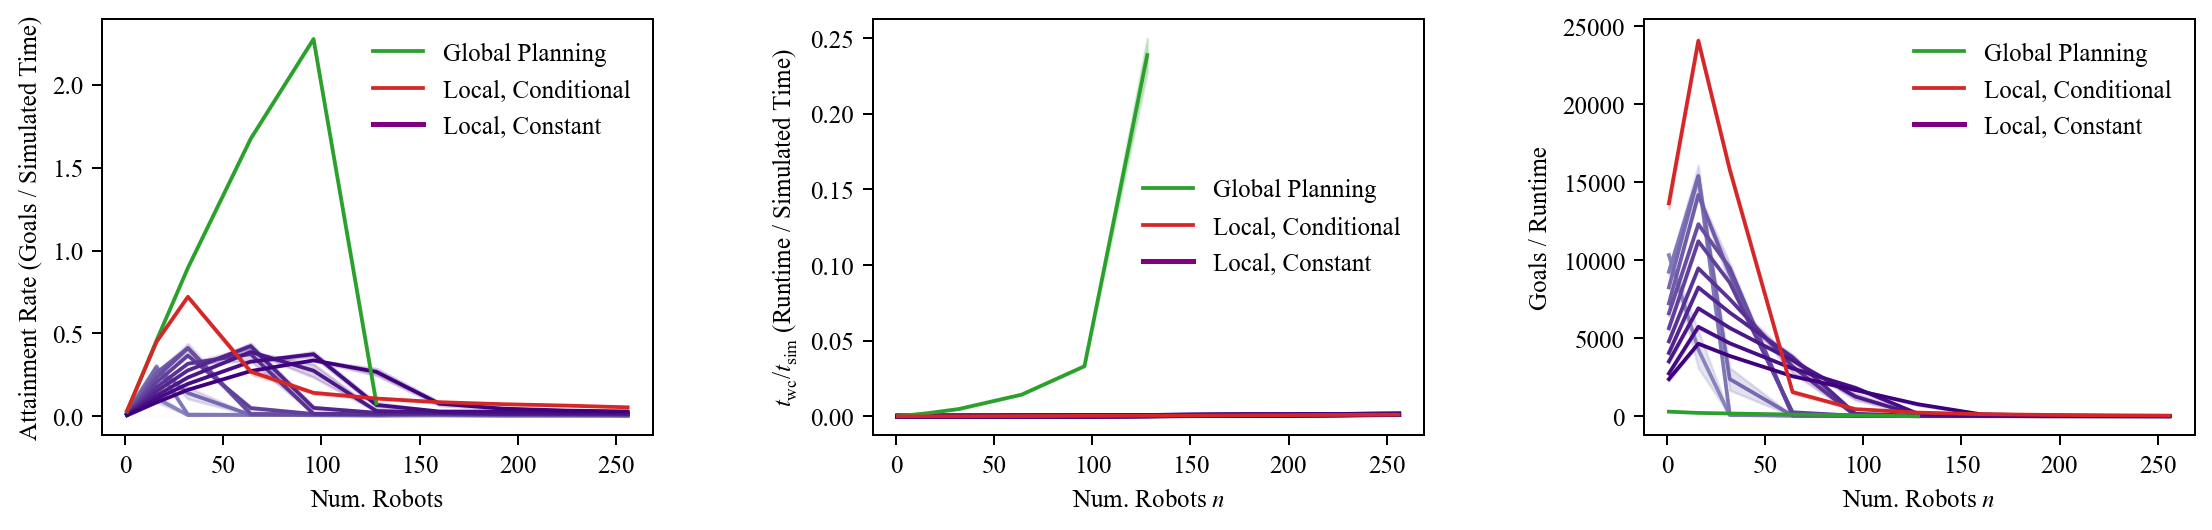

In [92]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
fig.subplots_adjust(wspace=0.4) 

# subplot a
sns.lineplot(data=ministage_latesim[(ministage_latesim['noise_type']=="constant noise")],
             ax=axs[0], 
             x = "num_robots", 
             y = "latesim_goal_rate", 
             hue = "noise",
             palette = "Purples",
             legend = False,
             errorbar='se')

sns.lineplot(data = astar_latesim[(astar_latesim["periodic"] == 1)], 
             ax=axs[0],
             x = "num_robots", 
             y = "latesim_goal_rate",
             errorbar='se',
             label = "Global Planning")



sns.lineplot(data=ministage_latesim[(ministage_latesim['noise_type']=="conditional noise")], 
             ax=axs[0],
             x = "num_robots", 
             y = "latesim_goal_rate", 
             errorbar='se',
             label = "Local, Conditional")



from matplotlib.lines import Line2D
# Create a single custom legend entry for the noise group
custom_noise_line = Line2D(
    [0], [0], color='purple', linewidth=2, label='Local, Constant'
)

# Append it to the current legend handles
handles, labels = axs[0].get_legend_handles_labels()
handles = handles + [custom_noise_line]
labels = labels + ['Local, Constant']

axs[0].legend(handles=handles, labels=labels, fontsize=10, frameon=False)
axs[0].set_xlabel("Num. Robots")
axs[0].set_ylabel("Attainment Rate (Goals / Simulated Time)")


# subplot b
sns.lineplot(data = ministage_stats_df[(ministage_stats_df['noise_type'] == 'constant noise')], 
             ax=axs[1],
             x = "num_robots", 
             y = ministage_stats_df[(ministage_stats_df['noise_type'] == 'constant noise')]['latesim_runtime'] / (end_time - time_cutoff),
             hue = "noise",
             palette = "Purples",
             errorbar='se',
             linewidth = 2,
             legend = False)

sns.lineplot(data=astar_planner_stats_df,
             ax=axs[1],
             x = "num_robots", 
             y = astar_planner_stats_df['latesim_runtime'] / (end_time - time_cutoff), # wall-clock second per simulated second
             label = "Global Planning",
             errorbar='se')

sns.lineplot(data = ministage_stats_df[ministage_stats_df['noise_type'] == 'conditional noise'], 
             ax=axs[1],
             x = "num_robots", 
             y = ministage_stats_df[(ministage_stats_df['noise_type'] == 'conditional noise')]['latesim_runtime'] / (end_time - time_cutoff),
             errorbar='se',
             linewidth = 1.5,
             label = "Local, Conditional")

custom_noise_line = Line2D(
    [0], [0], color='purple', linewidth=2, label='Local, Constant'
)

# Append it to the current legend handles
handles, labels = axs[1].get_legend_handles_labels()
handles = handles + [custom_noise_line]
labels = labels + ['Local, Constant']
axs[1].legend(handles=handles, labels=labels, fontsize=10, frameon=False)
axs[1].set_xlabel("Num. Robots $n$")
axs[1].set_ylabel("$t_{\\text{wc}} / t_{\\text{sim}}$ (Runtime / Simulated Time)")


# subplot c
sns.lineplot(data=cost_comparison_df[(cost_comparison_df['noise_type']=="constant noise")], 
             ax=axs[2],
             x = "num_robots", 
             y = "latesim_goals_per_runtime", 
             hue = "noise",
             palette = "Purples",
             legend = False,
             errorbar='se')

sns.lineplot(data = cost_comparison_df[(cost_comparison_df["periodic"] == 1) & (cost_comparison_df['noise_type'] == 'astar')], 
             ax=axs[2],
             x = "num_robots", 
             y = "latesim_goals_per_runtime",
             errorbar='se',
             label = "Global Planning")

sns.lineplot(data = cost_comparison_df[(cost_comparison_df["periodic"] == 1) & (cost_comparison_df['noise_type'] == 'conditional noise')], 
             ax=axs[2],
             x = "num_robots", 
             y = "latesim_goals_per_runtime",
             errorbar='se',
             label = "Local, Conditional")

custom_noise_line = Line2D(
    [0], [0], color='purple', linewidth=2, label='Local, Constant'
)

# Append it to the current legend handles
handles, labels = axs[2].get_legend_handles_labels()
handles = handles + [custom_noise_line]
labels = labels + ['Local, Constant']
axs[2].legend(handles=handles, labels=labels, fontsize=10, frameon=False)
axs[2].set_xlabel("Num. Robots $n$")
axs[2].set_ylabel("Goals / Runtime")


# plt.tight_layout()
plt.savefig("figures/fig4_intelligence_comparison.pdf")


## Compare efficiency of local approach

In [84]:
efficiency_comparison = np.round(cost_comparison_df.groupby(['noise_type', 'periodic', 'num_robots', 'noise'], observed = True).agg(avg_latesim_goals_per_runtime = ('latesim_goals_per_runtime', 'mean')).reset_index(), 4)
efficiency_comparison

,noise_type,periodic,num_robots,noise,avg_latesim_goals_per_runtime
0,astar,1,1,astar,301.2792
1,astar,1,16,astar,220.6853
2,astar,1,32,astar,184.6389
3,astar,1,64,astar,116.7682
4,astar,1,96,astar,68.7086
...,...,...,...,...,...
131,constant noise,1,256,1.1,8.6946
132,constant noise,1,256,1.2,12.8706
133,constant noise,1,256,1.3,11.0052
134,constant noise,1,256,1.4,18.2951


In [85]:
astar_best = efficiency_comparison[efficiency_comparison['noise_type'] == 'astar']['avg_latesim_goals_per_runtime'].max()
print(f"Highest Avg Goals per Runtime for a parameter setting using astar: {astar_best}")

conditional_noise_best = efficiency_comparison[efficiency_comparison['noise_type'] == 'conditional noise']['avg_latesim_goals_per_runtime'].max()
print(f"Highest Avg Goals per Runtime for a parameter setting using conditional noise: {conditional_noise_best}")

constant_noise_best = efficiency_comparison[efficiency_comparison['noise_type'] == 'constant noise']['avg_latesim_goals_per_runtime'].max()
print(f"Highest Avg Goals per Runtime for a parameter setting using constant noise: {constant_noise_best}")

Highest Avg Goals per Runtime for a parameter setting using astar: 301.2792
Highest Avg Goals per Runtime for a parameter setting using conditional noise: 24082.4525
Highest Avg Goals per Runtime for a parameter setting using constant noise: 15423.2231


In [86]:
print(f"Conditional noise has {conditional_noise_best / astar_best}x higher efficiency than the global planner")

Conditional noise has 79.93400307754402x higher efficiency than the global planner


In [87]:
print(f"Conditional noise has {conditional_noise_best / constant_noise_best}x higher efficiency than the local planner")

Conditional noise has 1.5614409740335016x higher efficiency than the local planner


## Compare with theory for the single robot, no noise, no traffic case

In [88]:
# theoretical prediction for average goal rate:
theory_notraffic_goal_rate = 0.5 / (0.3826 * 40) # v/(0.3826L) from main text eq3
theory_notraffic_goal_rate

0.032671197072660745

In [89]:
sim_notraffic_goal_rates = np.round(cost_comparison_df[cost_comparison_df['num_robots'] == 1].groupby(['noise_type', 'noise', 'periodic', 'num_robots'], observed = True).agg(avg_goal_rate = ('goal_rate', 'mean')).reset_index(), 4)
sim_notraffic_goal_rates

,noise_type,noise,periodic,num_robots,avg_goal_rate
0,astar,astar,1,1,0.0296
1,conditional noise,-1.0,1,1,0.0340
2,constant noise,-1.0,1,1,0.0002
3,constant noise,0.5,1,1,0.0258
4,constant noise,0.6,1,1,0.0233
5,constant noise,0.7,1,1,0.0207
6,constant noise,0.8,1,1,0.0183
7,constant noise,0.9,1,1,0.0159
8,constant noise,1.0,1,1,0.0143
9,constant noise,1.1,1,1,0.0118


In [90]:
astar_notraffic_goal_rate = sim_notraffic_goal_rates[sim_notraffic_goal_rates['noise_type'] == 'astar']['avg_goal_rate'].mean()
astar_notraffic_goal_rate

0.0296

In [91]:
# conditional noise with 1 robot and no traffic never adds noise
local_notraffic_goal_rate = sim_notraffic_goal_rates[sim_notraffic_goal_rates['noise_type'] == 'conditional noise']['avg_goal_rate'].mean()
local_notraffic_goal_rate

0.034